In [1]:
%pip install yfinance
%pip install matplotlib
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('seaborn')

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
tickers = 'AAPL,TSLA,MSFT,GM,BCS,QCOM,PTR,VALE,GS,CI,ENB,CB,LFC,MUFG,NVDA,ASML,ADBE,SONY,AMD,TXN,F,'
indices = 'SPY,'

md = yf.download(
    tickers = indices + tickers,
    group_by='ticker',
    start='2020-05-19', end='2021-05-19',
    interval = '1d',
    auto_adjust = True,
    threads = True
    )

print(f'Downloaded {len(md)} days of market data for indices : {indices} and tickers : {tickers}')

md['SPY'].tail()
print(f"Index : {md.index[:5]}...")
print(f"Columns : {md.columns[:5]}...")



[*********************100%***********************]  22 of 22 completed
Downloaded 253 days of market data for indices : SPY, and tickers : AAPL,TSLA,MSFT,GM,BCS,QCOM,PTR,VALE,GS,CI,ENB,CB,LFC,MUFG,NVDA,ASML,ADBE,SONY,AMD,TXN,F,
Index : DatetimeIndex(['2020-05-18', '2020-05-19', '2020-05-20', '2020-05-21',
               '2020-05-22'],
              dtype='datetime64[ns]', name='Date', freq=None)...
Columns : MultiIndex([('CI',   'Open'),
            ('CI',   'High'),
            ('CI',    'Low'),
            ('CI',  'Close'),
            ('CI', 'Volume')],
           )...


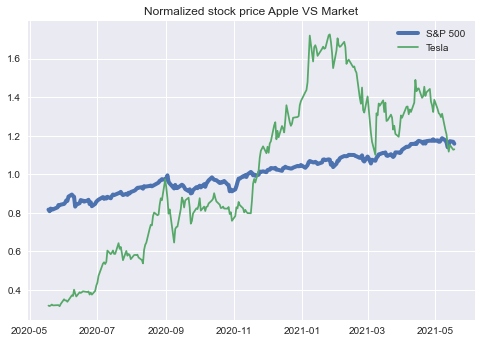

In [12]:
def plotNormalized(data, labelName, **kwargs):
    plt.plot(data / data.mean(), label = labelName, **kwargs)

plotNormalized(md['SPY'].Close, "S&P 500", linewidth = 4)
plotNormalized(md['AAPL'].Close, "Apple")
#plotNormalized(md['AMD'].Close, "AMD")
#plotNormalized(md['GM'].Close, "General Motors")
#plotNormalized(md['TSLA'].Close, "Tesla")
#plotNormalized(md['MUFG'].Close, "Mitsubishi UFJ Financial")
plt.title('Normalized stock price Apple VS Market')
plt.legend()
plt.show()


In [4]:
def getPriceAndReturn(md, **kwargs):
    priceField = 'Close'
    prices = pd.DataFrame()
    returns = pd.DataFrame()
    for ticker, kind in md.columns:
        if kind == priceField:
            prices[ticker] = md[ticker][[priceField]].values.reshape(1, -1).ravel()
            returns[ticker] = prices[ticker].pct_change(**kwargs)
    return prices, returns

prices, returns = getPriceAndReturn(md)

print(prices['SPY'].head())
print(returns['SPY'].head())



0    290.343842
1    287.361664
2    292.243408
3    290.225769
4    290.776947
Name: SPY, dtype: float64
0         NaN
1   -0.010271
2    0.016988
3   -0.006904
4    0.001899
Name: SPY, dtype: float64


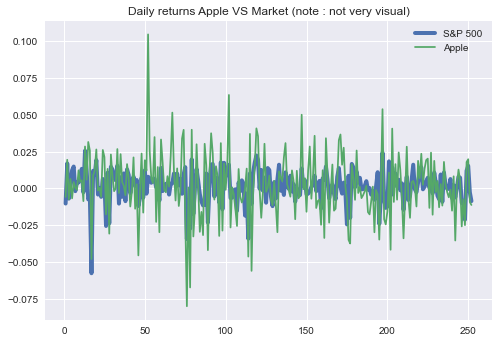

In [5]:
plt.plot(returns['SPY'], label = 'S&P 500', linewidth = 4)
plt.plot(returns['AAPL'], label = 'Apple')
plt.title("Daily returns Apple VS Market (note : not very visual)")
plt.legend()
plt.show()

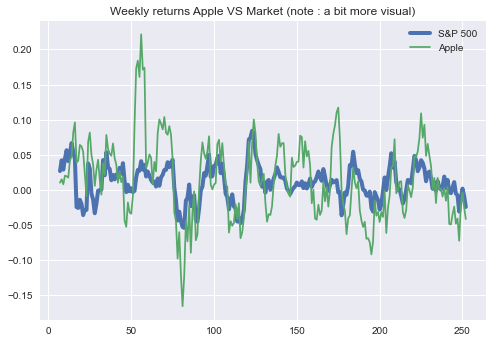

In [6]:
weeklyPrices, weeklyReturns = getPriceAndReturn(md, periods=7)

plt.plot(weeklyReturns['SPY'], label = 'S&P 500', linewidth = 4)
plt.plot(weeklyReturns['AAPL'], label = 'Apple')
plt.title("Weekly returns Apple VS Market (note : a bit more visual)")
plt.legend()
plt.show()


In [7]:
def getStats(prices, returns):
    mean = []
    std = []
    sharpe = []
    totReturn = []

    for ticker in returns.columns:
        pr = prices[ticker]
        ret = returns[ticker]

        totReturn.append((pr.iloc[-1] - pr.iloc[0]) / pr.iloc[0])
        mean.append(ret.mean())
        std.append(ret.std())

        sharpe.append(mean[-1] / std[-1] * (252**0.5)) #TODO consider adding risk free rate

    return pd.DataFrame.from_dict(
        {'DailyMean' : mean, 'DailyStd' : std, 'AnualSR' : sharpe, 'TotalReturn' : totReturn},
        orient='index', columns=returns.columns)

stats = getStats(prices, returns)

print(f"Daily return SPY mean : {stats['SPY']['DailyMean']}")
print(f"Daily return SPY std  : {stats['SPY']['DailyStd']}")

print(f"Basic return stats (mean, std, sharpe ratio, total return) :\n{stats}")

Daily return SPY mean : 0.0014474968820360192
Daily return SPY std  : 0.010791323551446576
Basic return stats (mean, std, sharpe ratio, total return) :
                   CI       TXN      TSLA        GM       BCS       PTR  \
DailyMean    0.001461  0.002044  0.006091  0.003590  0.003214  0.001146   
DailyStd     0.021279  0.018356  0.046060  0.027091  0.030634  0.022005   
AnualSR      1.089657  1.767859  2.099086  2.103608  1.665637  0.826531   
TotalReturn  0.365772  0.603762  2.551184  1.252721  1.000275  0.256974   

                 VALE      AAPL       AMD        GS  ...      MSFT       ENB  \
DailyMean    0.004174  0.002102  0.001694  0.003071  ...  0.001280  0.001179   
DailyStd     0.024523  0.022180  0.030751  0.021120  ...  0.017525  0.015030   
AnualSR      2.701746  1.504477  0.874549  2.308168  ...  1.159051  1.245412   
TotalReturn  1.650893  0.596282  0.363620  1.048213  ...  0.327944  0.308307   

                 MUFG       LFC      SONY        CB      ASML      QCOM

No handles with labels found to put in legend.


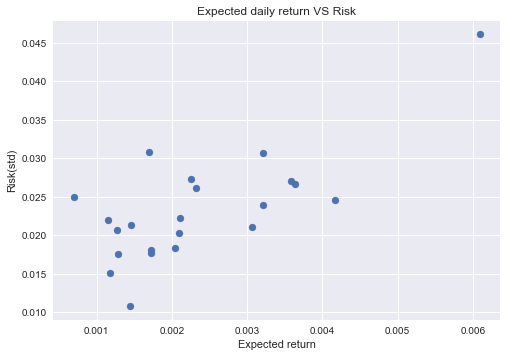

In [19]:
# See more on visualisation : https://kanoki.org/2019/09/16/dataframe-visualization-with-pandas-plot/
transposedStats = stats.transpose()
plt.scatter(transposedStats['DailyMean'], transposedStats['DailyStd'])
plt.legend()
plt.xlabel('Expected return')
plt.ylabel('Risk(std)')
plt.title("Expected daily return VS Risk")
plt.show()


In [8]:
def getCovAndCorr(returns, stats):
    cov = []
    corr = []

    for i in range(len(returns.columns)):
        covColumn = []
        corrColumn = []
        
        iname = returns.columns[i]
        for j in range(i):
            covColumn.append(cov[j][i])
            corrColumn.append(corr[j][i])
        iStd = stats[iname]["DailyStd"]
        covColumn.append(iStd * iStd)
        corrColumn.append(1)
        for j in range(i+1, len(returns.columns)):
            jname = returns.columns[j]
            jStd = stats[jname]["DailyStd"]
            tickerCov = returns[iname].cov(returns[jname])
            covColumn.append(tickerCov)
            corrColumn.append(tickerCov / (iStd * jStd))
        cov.append(covColumn)
        corr.append(corrColumn)

    covDf = pd.DataFrame(cov, index = returns.columns, columns = returns.columns)
    corrDf = pd.DataFrame(corr, index = returns.columns, columns = returns.columns)
    return covDf, corrDf

cov, corr = getCovAndCorr(returns, stats)

print(f"Correlation matrix :\n{corr}\n")
print(f"Test Correlation TSLA/MSFT: {returns['TSLA'].cov(returns['MSFT'])/(stats['TSLA']['DailyStd'] * stats['MSFT']['DailyStd'])}")
'''
print(f"Covariance :\n{cov}\n")
print(f"Test Covariance TSLA/MSFT: {returns['TSLA'].cov(returns['MSFT'])}")
print(f"Covarience SPY column :\n{cov['SPY']}")
print(f"Covarience TSLA row :\n{cov.loc['TSLA']}")
print(f"corr.loc['SPY','TSLA'] : {corr.loc['SPY','TSLA']}")
'''
print(f"corr.loc['TSLA','SPY'] : {corr.loc['TSLA','SPY']}")


Correlation matrix :
            CI       TXN      TSLA        GM       BCS       PTR      VALE  \
CI    1.000000  0.219068  0.009327  0.333242  0.323919  0.302511  0.178510   
TXN   0.219068  1.000000  0.421711  0.313491  0.276537  0.198752  0.454879   
TSLA  0.009327  0.421711  1.000000  0.066320  0.108554  0.085218  0.245919   
GM    0.333242  0.313491  0.066320  1.000000  0.505261  0.249896  0.324753   
BCS   0.323919  0.276537  0.108554  0.505261  1.000000  0.459117  0.369361   
PTR   0.302511  0.198752  0.085218  0.249896  0.459117  1.000000  0.341985   
VALE  0.178510  0.454879  0.245919  0.324753  0.369361  0.341985  1.000000   
AAPL  0.081552  0.530051  0.477201  0.057957  0.072863  0.064671  0.247689   
AMD   0.064646  0.539648  0.391549 -0.019413 -0.046718  0.060758  0.271666   
GS    0.399901  0.345927  0.167588  0.503267  0.666330  0.345617  0.395287   
ADBE  0.067559  0.593209  0.511124 -0.009457  0.021569  0.071403  0.252737   
SPY   0.461357  0.756329  0.464253  0.45684

In [9]:
def getAlphaBetaBenchmark(indices, tickers, cov, stats):
    #TODO consider adding risk free rate
    benchmark = {}
    for index in indices:
        alpha = []
        beta = []
        for ticker in tickers:
            indexVarience = cov[index][index]
            indexTickerCovarience = cov[index][ticker]
            indexTickerBeta = indexTickerCovarience / indexVarience
            indexTickerAlpha = stats[ticker]['TotalReturn'] - indexTickerBeta * stats[index]['TotalReturn']
            beta.append(indexTickerBeta)
            alpha.append(indexTickerAlpha)

        benchmark[index] = pd.DataFrame.from_dict({'Alpha' : alpha, 'Beta' : beta}, orient='index', columns=tickers)
    return benchmark

abBench = getAlphaBetaBenchmark(
    list(filter(None, indices.split(','))),
    list(filter(None, tickers.split(','))),
    cov, stats)

print(f"Alpa/Beta for SPY benchmark :\n{abBench['SPY']}")

Alpa/Beta for SPY benchmark :
           AAPL      TSLA      MSFT        GM       BCS      QCOM       PTR  \
Alpha  0.015872  1.721312 -0.172086  0.772418  0.437016  0.042966 -0.051308   
Beta   1.385885  1.981545  1.193959  1.146854  1.344935  1.446212  0.736107   

           VALE        GS        CI  ...        CB       LFC      MUFG  \
Alpha  1.165004  0.576772 -0.015219  ...  0.230395 -0.270370  0.156281   
Beta   1.160191  1.125695  0.909719  ...  0.905203  0.901178  0.783987   

           NVDA      ASML      ADBE      SONY       AMD       TXN         F  
Alpha -0.021738  0.521300 -0.200919  0.214130 -0.187396  0.064978  0.794848  
Beta   1.494100  1.352246  1.210740  0.641412  1.315700  1.286491  1.173361  

[2 rows x 21 columns]
